# NLP Binary classification with 

Notebook to prepare the tensorflow Certified Developer. 

Binary Text Classification 

Dataset from: 
https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv



## Import libraries

In [3]:
#First steep is import the libraries. 
import tensorflow as tf
tf.random.set_seed(42)
#Numpy is a lybrary that allow us to work with arrays. 
import numpy as np
#keras is an open source neural networks lybrary writted in python that run's in varios frameworks, TensorFlow included. 
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import csv

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.stats import linregress

#Tranfer learning from tensorhub
import tensorflow_hub as hub

print (tf.__version__)

gEpochs = 10

2.9.0


# Functions


In [4]:
#clear the text 
import re
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [39]:
def get_model(kindmodel):
    switcher = {
        #FLATTEN
        #6s 29ms/step - loss: 0.1044 - accuracy: 0.9891 - val_loss: 0.5866 - val_accuracy: 0.7477
        0:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]), 
        #GLOBALAVERAGE
        #s 37ms/step - loss: 0.4688 - accuracy: 0.8425 - val_loss: 0.5214 - val_accuracy: 0.7740
        1:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.GlobalAveragePooling1D(), 
            tf.keras.layers.Dense(6, activation='relu'), 
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #GlobalAverage + ExtraDense + Dropout
        #7s 33ms/step - loss: 0.4202 - accuracy: 0.8618 - val_loss: 0.5137 - val_accuracy: 0.8003
        11:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.GlobalAveragePooling1D(), 
            tf.keras.layers.Dense(6, activation='relu'), 
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dropout(0.4), 
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #LSTM Simple
        #33s 153ms/step - loss: 0.0234 - accuracy: 0.9902 - val_loss: 0.9812 - val_accuracy: 0.7083
        2:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]), 
        #LSTM Multiple with return
        #61s 282ms/step - loss: 0.0216 - accuracy: 0.9917 - val_loss: 1.1696 - val_accuracy: 0.6899
        3:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #LSTM Multiple with Dropouts
        # 60s 281ms/step - loss: 0.0772 - accuracy: 0.9591 - val_loss: 0.8664 - val_accuracy: 0.7687
        31:tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim), 
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #Convolutional GlobalMaxPooling
        #14s 63ms/step - loss: 0.0219 - accuracy: 0.9927 - val_loss: 0.8249 - val_accuracy: 0.7490
        4:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
            tf.keras.layers.GlobalMaxPooling1D(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')]),
        #Convolutional GlovalAveragePooling & Dropout
        #9s 41ms/step - loss: 0.2264 - accuracy: 0.9075 - val_loss: 0.6128 - val_accuracy: 0.7714
        5:tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(6, activation='relu'),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')])
    }
    return switcher.get(kindmodel, None)

In [6]:

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [7]:
#Get the data from the .csv without pandas. 
def parse_data(filename, xpos, ypos,  omitheaders=True, delimiter=',', returnlabels=True):
    tweets = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        if omitheaders:
            csvfile.readline()
        for line in reader:
            tweets.append(cleanText(line[xpos]))
            if returnlabels:
                labels.append(int(line[ypos]))
    
    return tweets, labels


In [8]:
#split the data in tarning / validate data 
def split_data(data, label, validation=10):
    validsize = int(len(data) * (validation / 100))
    total_length = len(data)
    v_data = data[0:validsize]
    t_data = data[validsize:]
    
    v_label = label[0:validsize]
    t_label = label[validsize:]
    
    return  t_data, t_label, v_data, v_label

### prepare the data for the model

In [9]:
traindatafile = "./Data/traindisaster.csv"
testdatafile = "./Data/testdisaster.csv"

In [10]:
with open(traindatafile, 'r') as train_df:
    print (train_df.readline())
    print (train_df.readline())

id,keyword,location,text,target

1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1



In [11]:
with open(testdatafile, 'r') as test_df:
    print (test_df.readline())
    print (test_df.readline())

id,keyword,location,text

0,,,Just happened a terrible car crash



In [12]:
x_traindata, y_traindata = parse_data(traindatafile, 3, 4)
print(x_traindata[0])
print(len(x_traindata))
print(y_traindata[0])



our deeds are the reason of this earthquake may allah forgive us all
7613
1


In [13]:
x_test, y_test = parse_data(testdatafile, 3, 0, returnlabels=False)

In [14]:
x_train, y_train, x_val, y_val=split_data(x_traindata, y_traindata, validation =10)
print (len(x_train))
print (len(y_train))
print (len(x_val))
print (len(y_val))
print (x_train[0])
print (x_val[0])

6852
6852
761
761
just realized my dude  was on that what are those way before it blew up  the tusky  game  
our deeds are the reason of this earthquake may allah forgive us all


In [15]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

vocab_size = 100000
max_length = 280
embedding_dim = 16


In [16]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(x_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = pad_sequences(validation_sequences, 
                               maxlen=max_length, truncating=trunc_type)

y_train = np.array(y_train)
y_val = np.array(y_val)

number of words in word_index: 17835


# Flatten



In [17]:
model0 = get_model(0)

# Setup the training parameters
model0.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model0.summary()

Metal device set to: Apple M1 Pro


2022-07-28 10:31:44.115533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-28 10:31:44.115683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 16)           1600000   
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 6)                 26886     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 1,626,893
Trainable params: 1,626,893
Non-trainable params: 0
_________________________________________________________________


In [18]:
history0 = model0.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 10:31:45.579751: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-28 10:31:45.781833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 10s 46ms/step - loss: 0.6579 - accuracy: 0.5959 - val_loss: 0.5853 - val_accuracy: 0.7556
Epoch 2/10
  1/215 [..............................] - ETA: 9s - loss: 0.5866 - accuracy: 0.6875

2022-07-28 10:31:55.660309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 8s 36ms/step - loss: 0.5276 - accuracy: 0.7995 - val_loss: 0.5293 - val_accuracy: 0.7753
Epoch 3/10
215/215 [==============================] - 7s 33ms/step - loss: 0.3962 - accuracy: 0.8948 - val_loss: 0.5096 - val_accuracy: 0.7806
Epoch 4/10
215/215 [==============================] - 7s 31ms/step - loss: 0.2877 - accuracy: 0.9498 - val_loss: 0.5100 - val_accuracy: 0.7806
Epoch 5/10
215/215 [==============================] - 7s 30ms/step - loss: 0.2193 - accuracy: 0.9720 - val_loss: 0.5240 - val_accuracy: 0.7582
Epoch 6/10
215/215 [==============================] - 6s 30ms/step - loss: 0.1779 - accuracy: 0.9812 - val_loss: 0.5315 - val_accuracy: 0.7451
Epoch 7/10
215/215 [==============================] - 6s 29ms/step - loss: 0.1508 - accuracy: 0.9864 - val_loss: 0.5469 - val_accuracy: 0.7451
Epoch 8/10
215/215 [==============================] - 6s 29ms/step - loss: 0.1317 - accuracy: 0.9872 - val_loss: 0.5559 - val_accuracy: 0.7464
Epoch 9/10

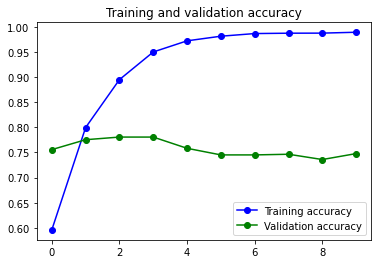

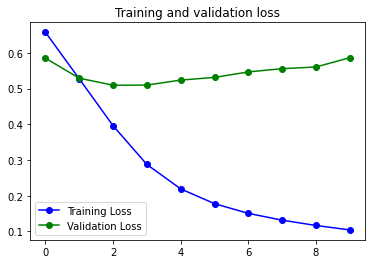

In [19]:
plot_loss_acc(history0)

## model 1 GlobalAverage


In [18]:
model1 = get_model(1)

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 280, 16)           1600000   
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 6)                 102       
                                                                 
 dense_22 (Dense)            (None, 1)                 7         
                                                                 
Total params: 1,600,109
Trainable params: 1,600,109
Non-trainable params: 0
_________________________________________________________________


In [19]:
history1 = model1.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10
  1/215 [..............................] - ETA: 1:18 - loss: 0.6949 - accuracy: 0.3750

2022-07-28 09:47:38.530420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 10s 46ms/step - loss: 0.6867 - accuracy: 0.5594 - val_loss: 0.6670 - val_accuracy: 0.6294
Epoch 2/10


2022-07-28 09:47:48.398913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 9s 44ms/step - loss: 0.6831 - accuracy: 0.5638 - val_loss: 0.6620 - val_accuracy: 0.6294
Epoch 3/10
215/215 [==============================] - 9s 44ms/step - loss: 0.6796 - accuracy: 0.5638 - val_loss: 0.6571 - val_accuracy: 0.6294
Epoch 4/10
215/215 [==============================] - 9s 44ms/step - loss: 0.6685 - accuracy: 0.5638 - val_loss: 0.6465 - val_accuracy: 0.6294
Epoch 5/10
215/215 [==============================] - 9s 43ms/step - loss: 0.6435 - accuracy: 0.5773 - val_loss: 0.6262 - val_accuracy: 0.6413
Epoch 6/10
215/215 [==============================] - 9s 41ms/step - loss: 0.6086 - accuracy: 0.6721 - val_loss: 0.5967 - val_accuracy: 0.6886
Epoch 7/10
215/215 [==============================] - 8s 39ms/step - loss: 0.5719 - accuracy: 0.7369 - val_loss: 0.5751 - val_accuracy: 0.7516
Epoch 8/10
215/215 [==============================] - 8s 39ms/step - loss: 0.5343 - accuracy: 0.7881 - val_loss: 0.5522 - val_accuracy: 0.7569
Epoch 9/10

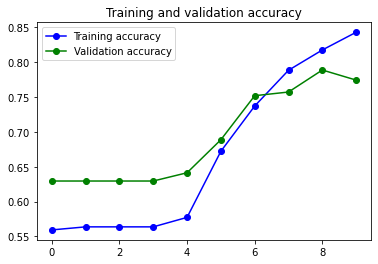

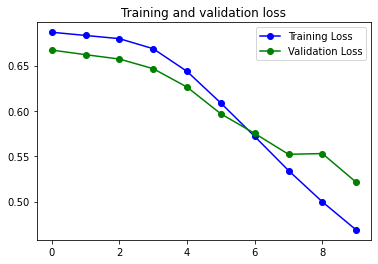

In [20]:
plot_loss_acc(history1)

In [21]:
model11 = get_model(11)

# Setup the training parameters
model11.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model11.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 280, 16)           1600000   
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_42 (Dense)            (None, 6)                 102       
                                                                 
 dense_43 (Dense)            (None, 6)                 42        
                                                                 
 dropout_8 (Dropout)         (None, 6)                 0         
                                                                 
 dense_44 (Dense)            (None, 1)                 7         
                                                     

In [22]:
history111 = model11.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 09:49:21.837361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 10s 45ms/step - loss: 0.6861 - accuracy: 0.5638 - val_loss: 0.6696 - val_accuracy: 0.6294
Epoch 2/10


2022-07-28 09:49:31.589648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 9s 43ms/step - loss: 0.6836 - accuracy: 0.5638 - val_loss: 0.6649 - val_accuracy: 0.6294
Epoch 3/10
215/215 [==============================] - 9s 42ms/step - loss: 0.6799 - accuracy: 0.5638 - val_loss: 0.6621 - val_accuracy: 0.6294
Epoch 4/10
215/215 [==============================] - 9s 42ms/step - loss: 0.6650 - accuracy: 0.5638 - val_loss: 0.6437 - val_accuracy: 0.6294
Epoch 5/10
215/215 [==============================] - 8s 39ms/step - loss: 0.6236 - accuracy: 0.5829 - val_loss: 0.6010 - val_accuracy: 0.6675
Epoch 6/10
215/215 [==============================] - 8s 36ms/step - loss: 0.5711 - accuracy: 0.7427 - val_loss: 0.5708 - val_accuracy: 0.7635
Epoch 7/10
215/215 [==============================] - 8s 35ms/step - loss: 0.5266 - accuracy: 0.7985 - val_loss: 0.5492 - val_accuracy: 0.7884
Epoch 8/10
215/215 [==============================] - 7s 34ms/step - loss: 0.4853 - accuracy: 0.8316 - val_loss: 0.5266 - val_accuracy: 0.7911
Epoch 9/10

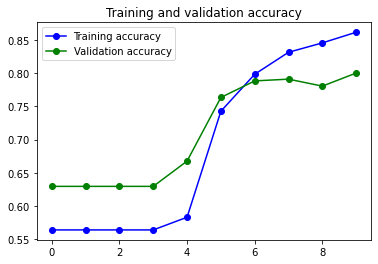

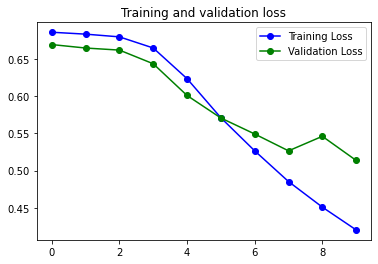

In [23]:
plot_loss_acc(history111)

## Single Layer LSTM

In [24]:
# Hyperparameters
embedding_dim = 64
lstm_dim = 64


# Build the model
model2 = get_model(2)

# Print the model summary
model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 64)          6400000   
                                                                 
 bidirectional_15 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_64 (Dense)            (None, 6)                 774       
                                                                 
 dense_65 (Dense)            (None, 1)                 7         
                                                                 
Total params: 6,466,829
Trainable params: 6,466,829
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history2 = model2.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 09:50:47.267918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:50:47.486375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:50:47.498212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:50:48.280638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:50:48.295388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.7192

2022-07-28 09:51:26.134851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:51:26.218370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:51:26.226021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 43s 183ms/step - loss: 0.5399 - accuracy: 0.7192 - val_loss: 0.4787 - val_accuracy: 0.7766
Epoch 2/10
215/215 [==============================] - 35s 165ms/step - loss: 0.2949 - accuracy: 0.8793 - val_loss: 0.4976 - val_accuracy: 0.7516
Epoch 3/10
215/215 [==============================] - 36s 168ms/step - loss: 0.1597 - accuracy: 0.9418 - val_loss: 0.6271 - val_accuracy: 0.7135
Epoch 4/10
215/215 [==============================] - 37s 172ms/step - loss: 0.0889 - accuracy: 0.9689 - val_loss: 0.7267 - val_accuracy: 0.7030
Epoch 5/10
215/215 [==============================] - 37s 171ms/step - loss: 0.0558 - accuracy: 0.9815 - val_loss: 0.9923 - val_accuracy: 0.6951
Epoch 6/10
215/215 [==============================] - 37s 172ms/step - loss: 0.0437 - accuracy: 0.9879 - val_loss: 0.8937 - val_accuracy: 0.7148
Epoch 7/10
215/215 [==============================] - 36s 169ms/step - loss: 0.0361 - accuracy: 0.9905 - val_loss: 0.9923 - val_accuracy: 0.7

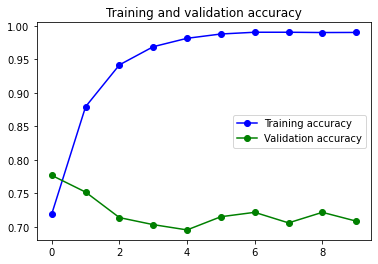

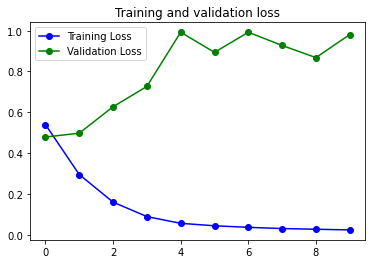

In [27]:
plot_loss_acc(history2)

# Multiple LSTM

In [28]:
# Build the model
model3 = get_model(3)
# Print the model summary
model3.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, None, 64)          6400000   
                                                                 
 bidirectional_21 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_85 (Dense)            (None, 6)                 390       
                                                                 
 dense_86 (Dense)            (None, 1)                 7         
                                                                 
Total params: 6,507,661
Trainable params: 6,507,661
N

In [29]:
# Set the training parameters
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
history3 = model3.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 09:56:52.708726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:56:53.121233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:56:53.131598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:56:53.781063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:56:53.791444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:56:54.546715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:56:54.562111: I tensorflow/core/grappler/optimizers/cust

215/215 [==============================] - ETA: 0s - loss: 0.5429 - accuracy: 0.7210

2022-07-28 09:57:59.463847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:57:59.603766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:57:59.611149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:58:00.262865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 09:58:00.270409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 75s 315ms/step - loss: 0.5429 - accuracy: 0.7210 - val_loss: 0.5090 - val_accuracy: 0.7385
Epoch 2/10
215/215 [==============================] - 60s 279ms/step - loss: 0.2893 - accuracy: 0.8867 - val_loss: 0.5460 - val_accuracy: 0.7122
Epoch 3/10
215/215 [==============================] - 61s 283ms/step - loss: 0.1423 - accuracy: 0.9511 - val_loss: 0.7266 - val_accuracy: 0.6859
Epoch 4/10
215/215 [==============================] - 61s 282ms/step - loss: 0.0807 - accuracy: 0.9750 - val_loss: 0.8556 - val_accuracy: 0.6965
Epoch 5/10
215/215 [==============================] - 61s 283ms/step - loss: 0.0512 - accuracy: 0.9863 - val_loss: 1.0183 - val_accuracy: 0.6675
Epoch 6/10
215/215 [==============================] - 61s 282ms/step - loss: 0.0455 - accuracy: 0.9880 - val_loss: 0.9975 - val_accuracy: 0.6820
Epoch 7/10
215/215 [==============================] - 61s 284ms/step - loss: 0.0371 - accuracy: 0.9911 - val_loss: 0.8664 - val_accuracy: 0.7

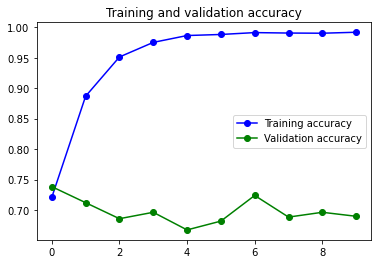

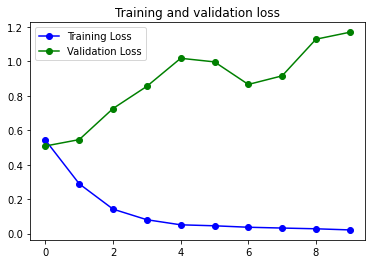

In [31]:
plot_loss_acc(history3)

In [32]:
# Build the model
model31 = get_model(31)
# Print the model summary
model31.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 64)          6400000   
                                                                 
 bidirectional_28 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_106 (Dense)           (None, 6)                 390       
                                                                 
 dropout_22 (Dropout)        (None, 6)               

In [33]:
# Set the training parameters
model31.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history31 = model31.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 10:07:16.192260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:07:16.585060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:07:16.595752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:07:17.251684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:07:17.262168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:07:18.076917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:07:18.092437: I tensorflow/core/grappler/optimizers/cust

215/215 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.6986

2022-07-28 10:08:22.921375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:08:23.061010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:08:23.068538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:08:23.732331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 10:08:23.739833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 75s 315ms/step - loss: 0.5772 - accuracy: 0.6986 - val_loss: 0.4883 - val_accuracy: 0.7911
Epoch 2/10
215/215 [==============================] - 60s 281ms/step - loss: 0.3546 - accuracy: 0.8555 - val_loss: 0.5146 - val_accuracy: 0.7792
Epoch 3/10
215/215 [==============================] - 60s 281ms/step - loss: 0.2131 - accuracy: 0.9171 - val_loss: 0.5731 - val_accuracy: 0.7490
Epoch 4/10
215/215 [==============================] - 61s 284ms/step - loss: 0.1410 - accuracy: 0.9457 - val_loss: 0.6508 - val_accuracy: 0.7766
Epoch 5/10
215/215 [==============================] - 62s 287ms/step - loss: 0.0982 - accuracy: 0.9562 - val_loss: 0.8343 - val_accuracy: 0.7424
Epoch 6/10
215/215 [==============================] - 62s 289ms/step - loss: 0.0895 - accuracy: 0.9577 - val_loss: 0.7356 - val_accuracy: 0.7214
Epoch 7/10
215/215 [==============================] - 63s 291ms/step - loss: 0.0782 - accuracy: 0.9638 - val_loss: 0.8154 - val_accuracy: 0.7

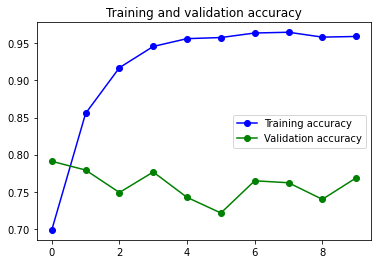

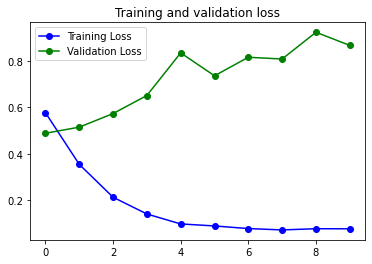

In [35]:
plot_loss_acc(history31)

# Convolutional Model

In [36]:
# Build the model
model4 = get_model(4)
# Print the model summary
model4.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 280, 64)           6400000   
                                                                 
 conv1d_18 (Conv1D)          (None, 276, 64)           20544     
                                                                 
 global_max_pooling1d_12 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_127 (Dense)           (None, 6)                 390       
                                                                 
 dense_128 (Dense)           (None, 1)                 7         
                                                                 
Total params: 6,420,941
Trainable params: 6,420,941
Non-trainable params: 0
___________________________________________

In [37]:
# Set the training parameters
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history4 = model4.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 10:17:41.884367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.7077

2022-07-28 10:17:56.688862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 16s 69ms/step - loss: 0.5639 - accuracy: 0.7077 - val_loss: 0.4617 - val_accuracy: 0.7950
Epoch 2/10
215/215 [==============================] - 14s 65ms/step - loss: 0.3195 - accuracy: 0.8703 - val_loss: 0.4518 - val_accuracy: 0.8003
Epoch 3/10
215/215 [==============================] - 14s 64ms/step - loss: 0.1674 - accuracy: 0.9444 - val_loss: 0.5070 - val_accuracy: 0.7989
Epoch 4/10
215/215 [==============================] - 14s 65ms/step - loss: 0.0819 - accuracy: 0.9743 - val_loss: 0.6290 - val_accuracy: 0.7490
Epoch 5/10
215/215 [==============================] - 14s 64ms/step - loss: 0.0503 - accuracy: 0.9845 - val_loss: 0.7036 - val_accuracy: 0.7516
Epoch 6/10
215/215 [==============================] - 14s 64ms/step - loss: 0.0341 - accuracy: 0.9901 - val_loss: 0.7347 - val_accuracy: 0.7503
Epoch 7/10
215/215 [==============================] - 14s 64ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.7606 - val_accuracy: 0.7714
Epo

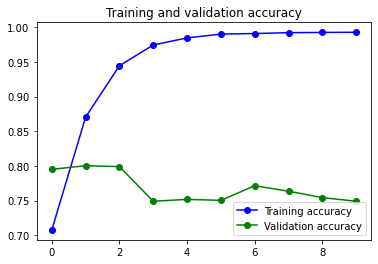

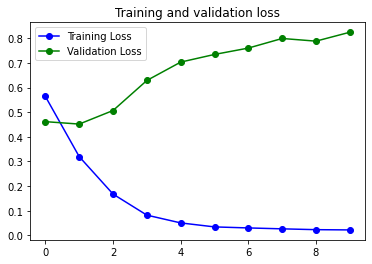

In [38]:
plot_loss_acc(history4)

In [40]:
# Build the model
model5 = get_model(5)
# Print the model summary
model5.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 280, 16)           1600000   
                                                                 
 conv1d_11 (Conv1D)          (None, 276, 32)           2592      
                                                                 
 dropout_16 (Dropout)        (None, 276, 32)           0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_78 (Dense)            (None, 6)                 198       
                                                                 
 dropout_17 (Dropout)        (None, 6)                 0         
                                                     

In [41]:
# Set the training parameters
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history5 = model5.fit(padded, y_train, epochs=gEpochs, 
          validation_data=(validation_padded, y_val))

Epoch 1/10


2022-07-28 11:46:03.265930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.5633

2022-07-28 11:46:14.147218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 11s 50ms/step - loss: 0.6850 - accuracy: 0.5633 - val_loss: 0.6491 - val_accuracy: 0.6294
Epoch 2/10
215/215 [==============================] - 9s 41ms/step - loss: 0.6381 - accuracy: 0.5769 - val_loss: 0.5804 - val_accuracy: 0.6702
Epoch 3/10
215/215 [==============================] - 8s 36ms/step - loss: 0.5640 - accuracy: 0.7585 - val_loss: 0.5459 - val_accuracy: 0.7516
Epoch 4/10
215/215 [==============================] - 7s 35ms/step - loss: 0.5099 - accuracy: 0.8203 - val_loss: 0.5432 - val_accuracy: 0.7556
Epoch 5/10
215/215 [==============================] - 7s 33ms/step - loss: 0.4592 - accuracy: 0.8463 - val_loss: 0.5268 - val_accuracy: 0.7753
Epoch 6/10
215/215 [==============================] - 7s 32ms/step - loss: 0.4133 - accuracy: 0.8708 - val_loss: 0.5256 - val_accuracy: 0.7806
Epoch 7/10
215/215 [==============================] - 8s 37ms/step - loss: 0.3586 - accuracy: 0.8828 - val_loss: 0.5298 - val_accuracy: 0.7779
Epoch 8/1

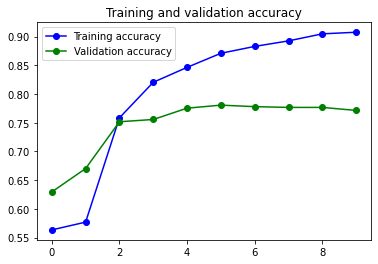

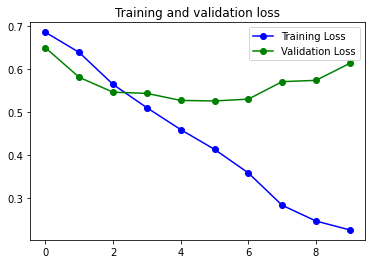

In [42]:
plot_loss_acc(history5)

# Transfer learning from TensorHub

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")


2022-07-28 10:33:31.328207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
train = pd.read_csv(traindatafile)
test = pd.read_csv(testdatafile)

In [23]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [24]:
tweets = train['text']
targets = train['target']

In [25]:
train_tweets , val_tweets , train_targets, val_targets = train_test_split(tweets.to_numpy(), targets.to_numpy(), test_size=0.2)
print(train_tweets[0]) 

Lee does comedy: ÛÏ@LeeJasper: Working class Tories prepare for your Armageddon. #InterestRateRiseÛ


In [26]:
modeltl0 = tf.keras.Sequential()
modeltl0.add(use_layer)
modeltl0.add(tf.keras.layers.Dense(128,activation='relu'))
modeltl0.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
modeltl0.compile(loss= "binary_crossentropy", optimizer = 'adam',metrics=["accuracy"])
modeltl0.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [27]:
historytl0 = modeltl0.fit(train_tweets, train_targets, epochs=gEpochs, 
                          validation_data=(val_tweets, val_targets))

Epoch 1/10


2022-07-28 10:33:59.060858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.7824

2022-07-28 10:34:06.211554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 10s 46ms/step - loss: 0.4973 - accuracy: 0.7824 - val_loss: 0.4179 - val_accuracy: 0.8162
Epoch 2/10
191/191 [==============================] - 7s 36ms/step - loss: 0.4150 - accuracy: 0.8136 - val_loss: 0.4058 - val_accuracy: 0.8260
Epoch 3/10
191/191 [==============================] - 7s 34ms/step - loss: 0.3988 - accuracy: 0.8218 - val_loss: 0.4008 - val_accuracy: 0.8234
Epoch 4/10
191/191 [==============================] - 7s 35ms/step - loss: 0.3892 - accuracy: 0.8307 - val_loss: 0.4031 - val_accuracy: 0.8201
Epoch 5/10
191/191 [==============================] - 7s 34ms/step - loss: 0.3771 - accuracy: 0.8353 - val_loss: 0.4011 - val_accuracy: 0.8175
Epoch 6/10
191/191 [==============================] - 7s 35ms/step - loss: 0.3682 - accuracy: 0.8389 - val_loss: 0.4022 - val_accuracy: 0.8240
Epoch 7/10
191/191 [==============================] - 7s 34ms/step - loss: 0.3578 - accuracy: 0.8465 - val_loss: 0.3992 - val_accuracy: 0.8234
Epoch 8/1

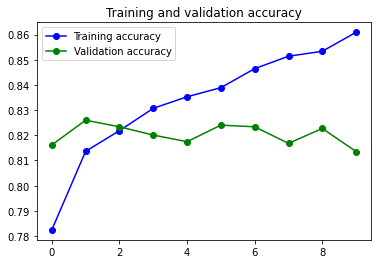

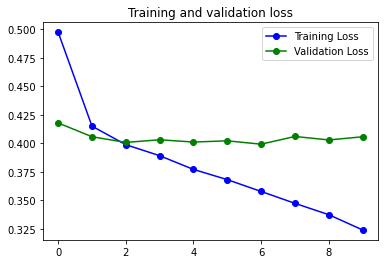

In [28]:
plot_loss_acc(historytl0)